# Base de dados
Este é um conjunto de dados de transações de cartão de crédito simulado contendo transações legítimas e fraudulentas de 1º de janeiro de 2019 a 31 de dezembro de 2020.
- fonte: https://www.kaggle.com/datasets/kartik2112/fraud-detection

# 1. Importação de bibliotecas

In [165]:
#Instalação para utilização do BayesSearchCV
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:

import numpy as np
import pandas as pd
import pickle, gzip


import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import roc_curve, auc, roc_auc_score,confusion_matrix,classification_report,accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from skopt import BayesSearchCV
from xgboost import XGBClassifier


# 2. Carregamento de dados

In [167]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit Card fraud/fraudTrain.csv')

In [168]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [169]:
test =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit Card fraud/fraudTest.csv')

In [170]:
test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


# 3. Exploração dos dados

Serão retirados 11 atributos/colunas que aparentemente não terão grande influência para a previsão das fraudes

In [171]:
drop = ['Unnamed: 0', 'cc_num','merchant','first', 'last', 'street','zip','job','trans_num','unix_time','city']
train.drop(columns = drop, axis=1, inplace=True)

In [172]:
train.head()

,trans_date_trans_time,category,amt,gender,state,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,misc_net,4.97,F,NC,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0
1,2019-01-01 00:00:44,grocery_pos,107.23,F,WA,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0
2,2019-01-01 00:00:51,entertainment,220.11,M,ID,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0
3,2019-01-01 00:01:16,gas_transport,45.00,M,MT,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0
4,2019-01-01 00:03:06,misc_pos,41.96,M,VA,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0


In [173]:
test.drop(columns = drop, axis=1, inplace=True)

In [174]:
test.head()

,trans_date_trans_time,category,amt,gender,state,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,personal_care,2.86,M,SC,33.9659,-80.9355,333497,1968-03-19,33.986391,-81.200714,0
1,2020-06-21 12:14:33,personal_care,29.84,F,UT,40.3207,-110.4360,302,1990-01-17,39.450498,-109.960431,0
2,2020-06-21 12:14:53,health_fitness,41.28,F,NY,40.6729,-73.5365,34496,1970-10-21,40.495810,-74.196111,0
3,2020-06-21 12:15:15,misc_pos,60.05,M,FL,28.5697,-80.8191,54767,1987-07-25,28.812398,-80.883061,0
4,2020-06-21 12:15:17,travel,3.19,M,MI,44.2529,-85.0170,1126,1955-07-06,44.959148,-85.884734,0


In [175]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   category               1296675 non-null  object 
 2   amt                    1296675 non-null  float64
 3   gender                 1296675 non-null  object 
 4   state                  1296675 non-null  object 
 5   lat                    1296675 non-null  float64
 6   long                   1296675 non-null  float64
 7   city_pop               1296675 non-null  int64  
 8   dob                    1296675 non-null  object 
 9   merch_lat              1296675 non-null  float64
 10  merch_long             1296675 non-null  float64
 11  is_fraud               1296675 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 118.7+ MB


In [176]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   category               555719 non-null  object 
 2   amt                    555719 non-null  float64
 3   gender                 555719 non-null  object 
 4   state                  555719 non-null  object 
 5   lat                    555719 non-null  float64
 6   long                   555719 non-null  float64
 7   city_pop               555719 non-null  int64  
 8   dob                    555719 non-null  object 
 9   merch_lat              555719 non-null  float64
 10  merch_long             555719 non-null  float64
 11  is_fraud               555719 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 50.9+ MB


A população entre cidades (city_pop) tem grande desvio padrão: 301.956,4, pois há grande variação populacional - o mínimo é de 23 e o máximo de 2.906.700. 

In [177]:
train.describe()

,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,7.035104e+01,3.853762e+01,-9.022634e+01,8.882444e+04,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.603160e+02,5.075808e+00,1.375908e+01,3.019564e+05,5.109788e+00,1.377109e+01,7.586269e-02
min,1.000000e+00,2.002710e+01,-1.656723e+02,2.300000e+01,1.902779e+01,-1.666712e+02,0.000000e+00
25%,9.650000e+00,3.462050e+01,-9.679800e+01,7.430000e+02,3.473357e+01,-9.689728e+01,0.000000e+00
50%,4.752000e+01,3.935430e+01,-8.747690e+01,2.456000e+03,3.936568e+01,-8.743839e+01,0.000000e+00
75%,8.314000e+01,4.194040e+01,-8.015800e+01,2.032800e+04,4.195716e+01,-8.023680e+01,0.000000e+00
max,2.894890e+04,6.669330e+01,-6.795030e+01,2.906700e+06,6.751027e+01,-6.695090e+01,1.000000e+00


Transformar o atributo 'trans_date_trans_time em tipo 'datetime' e extrair somente a hora, que é o valor mais relevante para detectar fraude. Este atributo chamará 'hour' e o atributo 'trans_date_trans_time' será retirado do dataframe.

In [178]:
train['trans_date_trans_time'] = pd.to_datetime(train['trans_date_trans_time'])
train['hour'] = train['trans_date_trans_time'].dt.hour
train = train.drop('trans_date_trans_time', axis=1)

Para que seja possível manipular o atributo 'hora' na etapa de 'machine learning', este será transformado em número inteiro.

In [179]:
train['hour'] = train.hour.astype('int64')

In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 12 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   category    1296675 non-null  object 
 1   amt         1296675 non-null  float64
 2   gender      1296675 non-null  object 
 3   state       1296675 non-null  object 
 4   lat         1296675 non-null  float64
 5   long        1296675 non-null  float64
 6   city_pop    1296675 non-null  int64  
 7   dob         1296675 non-null  object 
 8   merch_lat   1296675 non-null  float64
 9   merch_long  1296675 non-null  float64
 10  is_fraud    1296675 non-null  int64  
 11  hour        1296675 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 118.7+ MB


In [181]:
test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])
test['hour'] = test['trans_date_trans_time'].dt.hour
test = test.drop('trans_date_trans_time', axis=1)

In [182]:
test['hour'] = test.hour.astype('int64')

In [183]:
train.columns

Index(['category', 'amt', 'gender', 'state', 'lat', 'long', 'city_pop', 'dob',
       'merch_lat', 'merch_long', 'is_fraud', 'hour'],
      dtype='object')

Será transformado 'dob' em datetime e extraído o valor do ano e colocada em um atributo chamado 'yb' - year of birth. A coluna 'dob' será então renomeada. Infere-se que o valor do ano é o mais relevante para análise da fraude, já que é nele que se verifica qual a idade do usuário e desta forma, analisa se o perfil é de idoso ou jovem.

In [184]:
train['dob'] = pd.to_datetime(train['dob'])
train['dob'] = pd.DatetimeIndex(train['dob']).year
train = train.rename(columns= {'dob':'yb'})
train

,category,amt,gender,state,lat,long,city_pop,yb,merch_lat,merch_long,is_fraud,hour
0,misc_net,4.97,F,NC,36.0788,-81.1781,3495,1988,36.011293,-82.048315,0,0
1,grocery_pos,107.23,F,WA,48.8878,-118.2105,149,1978,49.159047,-118.186462,0,0
2,entertainment,220.11,M,ID,42.1808,-112.2620,4154,1962,43.150704,-112.154481,0,0
3,gas_transport,45.00,M,MT,46.2306,-112.1138,1939,1967,47.034331,-112.561071,0,0
4,misc_pos,41.96,M,VA,38.4207,-79.4629,99,1986,38.674999,-78.632459,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,M,UT,37.7175,-112.4777,258,1961,36.841266,-111.690765,0,12
1296671,food_dining,51.70,M,MD,39.2667,-77.5101,100,1979,38.906881,-78.246528,0,12
1296672,food_dining,105.93,M,NM,32.9396,-105.8189,899,1967,33.619513,-105.130529,0,12
1296673,food_dining,74.90,M,SD,43.3526,-102.5411,1126,1980,42.788940,-103.241160,0,12


O mesmo será feito para a base de dados de teste

In [185]:
#test['trans_date_trans_time'] = pd.to_datetime(test['trans_date_trans_time'])
test['dob'] = pd.to_datetime(test['dob'])
test['dob'] = pd.DatetimeIndex(test['dob']).year
test = test.rename(columns= {'dob':'yb'})
test

,category,amt,gender,state,lat,long,city_pop,yb,merch_lat,merch_long,is_fraud,hour
0,personal_care,2.86,M,SC,33.9659,-80.9355,333497,1968,33.986391,-81.200714,0,12
1,personal_care,29.84,F,UT,40.3207,-110.4360,302,1990,39.450498,-109.960431,0,12
2,health_fitness,41.28,F,NY,40.6729,-73.5365,34496,1970,40.495810,-74.196111,0,12
3,misc_pos,60.05,M,FL,28.5697,-80.8191,54767,1987,28.812398,-80.883061,0,12
4,travel,3.19,M,MI,44.2529,-85.0170,1126,1955,44.959148,-85.884734,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
555714,health_fitness,43.77,M,MO,40.4931,-91.8912,519,1966,39.946837,-91.333331,0,23
555715,kids_pets,111.84,M,TX,29.0393,-95.4401,28739,1999,29.661049,-96.186633,0,23
555716,kids_pets,86.88,F,WA,46.1966,-118.9017,3684,1981,46.658340,-119.715054,0,23
555717,travel,7.99,M,ID,44.6255,-116.4493,129,1965,44.470525,-117.080888,0,23


In [187]:
train.head()

,category,amt,gender,state,lat,long,city_pop,yb,merch_lat,merch_long,is_fraud,hour
0,misc_net,4.97,F,NC,36.0788,-81.1781,3495,1988,36.011293,-82.048315,0,0
1,grocery_pos,107.23,F,WA,48.8878,-118.2105,149,1978,49.159047,-118.186462,0,0
2,entertainment,220.11,M,ID,42.1808,-112.2620,4154,1962,43.150704,-112.154481,0,0
3,gas_transport,45.00,M,MT,46.2306,-112.1138,1939,1967,47.034331,-112.561071,0,0
4,misc_pos,41.96,M,VA,38.4207,-79.4629,99,1986,38.674999,-78.632459,0,0


In [188]:
train.category.unique()

array(['misc_net', 'grocery_pos', 'entertainment', 'gas_transport',
       'misc_pos', 'grocery_net', 'shopping_net', 'shopping_pos',
       'food_dining', 'personal_care', 'health_fitness', 'travel',
       'kids_pets', 'home'], dtype=object)

Para maior eficiência do treinamento nos estimadores de "machine learning", os dados da categoria ('category') serão renomeados com siglas e transformados em formato categórico.

In [189]:
train.replace({'misc_net': 'MN', 'grocery_pos':'GP', 'entertainment':'EN', 'gas_transport':'GT',
       'misc_pos':'MP', 'grocery_net':'GN', 'shopping_net':'SN', 'shopping_pos':'SP',
       'food_dining':'FD', 'personal_care':'PC', 'health_fitness':'HF', 'travel':'T',
       'kids_pets':'KP', 'home':'H'}, inplace=True)

In [190]:
train.category.unique()

array(['MN', 'GP', 'EN', 'GT', 'MP', 'GN', 'SN', 'SP', 'FD', 'PC', 'HF',
       'T', 'KP', 'H'], dtype=object)

In [191]:
train['category'] = train.category.astype('category')

O mesmo será feito para a base de teste

In [192]:
test.replace({'misc_net': 'MN', 'grocery_pos':'GP', 'entertainment':'EN', 'gas_transport':'GT',
       'misc_pos':'MP', 'grocery_net':'GN', 'shopping_net':'SN', 'shopping_pos':'SP',
       'food_dining':'FD', 'personal_care':'PC', 'health_fitness':'HF', 'travel':'T',
       'kids_pets':'KP', 'home':'H'}, inplace=True)

In [193]:
test.category.unique()

array(['PC', 'HF', 'MP', 'T', 'KP', 'SP', 'FD', 'H', 'EN', 'SN', 'MN',
       'GP', 'GT', 'GN'], dtype=object)

In [194]:
test['category'] = test.category.astype('category')

O 'gender' serão transformados em binários. 

In [195]:
train.gender.unique()

array(['F', 'M'], dtype=object)

In [196]:
train.replace({'F':0, 'M':1}, inplace=True)

In [197]:
train.gender.unique()

array([0, 1])

In [198]:
train['gender'] = train['gender'].astype('category')

In [199]:
test.replace({'F':0, 'M':1}, inplace=True)
test.gender.unique()

array([1, 0])

In [200]:
test['gender'] = test['gender'].astype('category')

# 4. Visualização de dados

In [201]:
state_fraud = train.groupby('state')['is_fraud'].sum().sort_values(ascending=False)
state_fraud = pd.DataFrame(state_fraud).reset_index()
state_fraud

,state,is_fraud
0,NY,555
1,TX,479
2,PA,458
3,CA,326
4,OH,321
5,FL,281
6,IL,248
7,MI,238
8,AL,215
9,MN,207


15 estados concentram 56,61% das fraudes do total

In [202]:
(state_fraud.is_fraud[:15].sum())/(state_fraud.is_fraud.sum())

0.566613375965894

O maior número de fraudes estão nos estados de Nova Yorque (NY), Texas (TX), Pensilvânia (PA), Califórnia (CA), Ohio (OH), Flórida (FL), Illinois (IL). Os estados da Califórnia, Texas, Flórida, Nova Yorque, Pensilvânia , Illinois e Ohio, são respectivamente, os de maior população segundo o Censo 2020 - fonte: https://pt.wikipedia.org/wiki/Lista_de_estados_dos_Estados_Unidos_por_popula%C3%A7%C3%A3o 
Portanto, a ordem da maior para a menor poulação por Estado é a seguinte:

1. Califórnia,
2. Texas, 
3. Flórida, 
4. Nova Yorque, 
5. Pensilvânia , 
6. Illinois e 
7. Ohio,

Já o número de fraudes tem a seguinte ordem por Estado:
1. Nova Yorque (NY), 
2. Texas (TX), 
3. Pensilvânia (PA), 
4. Califórnia (CA), 
5. Ohio (OH), 
6. Flórida (FL), 
7. Illinois (IL).

Apesar da Califórnia ser a mais populosa, ela está em quarto em número de fraudes. Já Texas obteve a mesma colocação no número de fraudes e nível populacional. Outros estados possuem divergências entre ambas as classificações, portanto, apesar de todas estarem entre os top 7, elas não estão estritamente proporcionais entre o número de fraude e concentração populacional. Portanto, vê-se que os estados com as maiores populações possuem mais fraudes, mas estas não estão na mesma ordem de grandeza que a classifição populacional.

Text(0.5, 1.0, 'Number of frauds in each State')

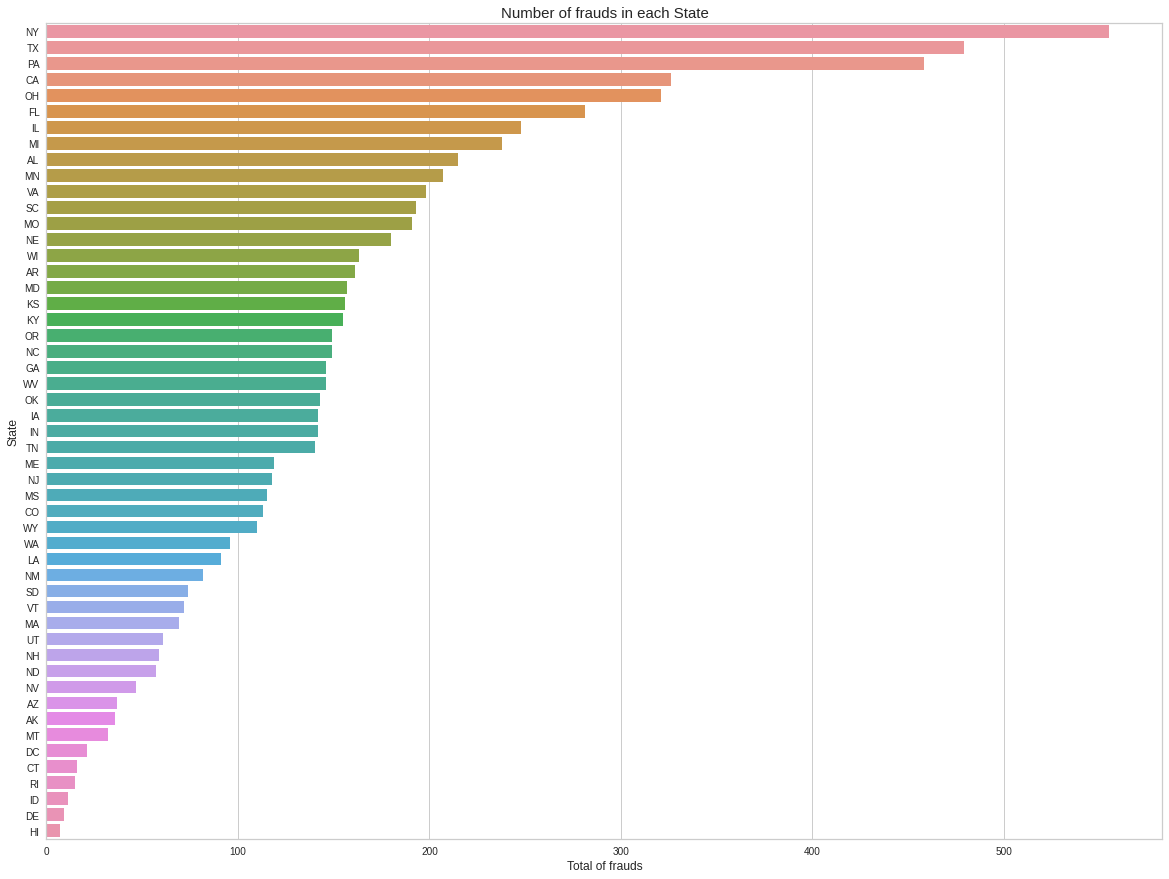

In [203]:
plt.figure(figsize=(20,15))
sns.barplot(data = state_fraud,y= 'state',x='is_fraud', orient='h', order=state_fraud.sort_values(by='is_fraud', ascending=False).state)
plt.xlabel("Total of frauds", size=12)
plt.ylabel("State", size=12)
plt.title("Number of frauds in each State", size=15)

Conforme percebe-se no gráfico, as transações fraudulentas ocorrem em valores menores do que as transações legítimas

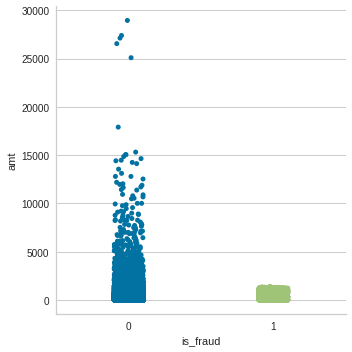

In [204]:
sns.catplot(y = 'amt',x='is_fraud', data = train)
plt.show()

As fraudes acontecem em sua grande maioria à noite, com seu pico entre 22h - 23h e diminuindo seu fluxo a partir da 00h até 3h. Depois das 3h as fraudes diminuem drasticamente.

In [205]:
hour_fraud = train.groupby('hour')['is_fraud'].sum()
hour_fraud

hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
Name: is_fraud, dtype: int64

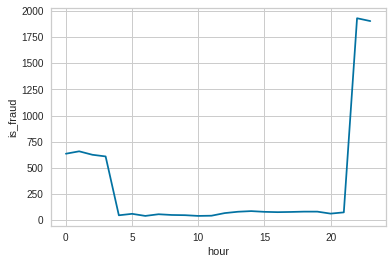

In [206]:
sns.lineplot(data=hour_fraud)


In [207]:
yb = train.groupby('yb')['is_fraud'].sum()
yb

yb
1924     0
1925    11
1926    25
1927    47
1928    41
        ..
2000    57
2001    58
2003    21
2004    32
2005     7
Name: is_fraud, Length: 81, dtype: int64

As fraudes acontecem menos em pessoas mais idosas, devido provavelmente a este grupo não ter tanto costume de usar cartão de crédito ou fazer compras online. Considerando que os dados foram coletados entre 2019 e 2020, entre 1960 e 1990 há um incremento de fraudes, diminuindo aproximadamente a partir do ano de 1997.

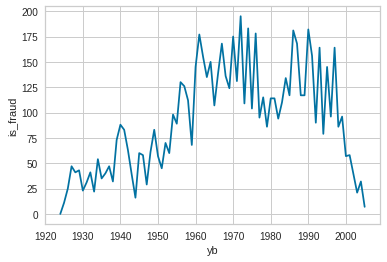

In [208]:
sns.lineplot(data=yb)

In [209]:
cat = train.groupby('category')['is_fraud'].sum()
cat = pd.DataFrame(cat).reset_index()
cat

,category,is_fraud
0,EN,233
1,FD,151
2,GN,134
3,GP,1743
4,GT,618
5,H,198
6,HF,133
7,KP,239
8,MN,915
9,MP,250


As fraudes acontecem, respectivamente, mais nas categorias: 'grocery_pos (GP), 'shopping_net'(SP), 'misc_net' (MN), 'shopping_pos' (SP) e 'gas_transport' (GT).

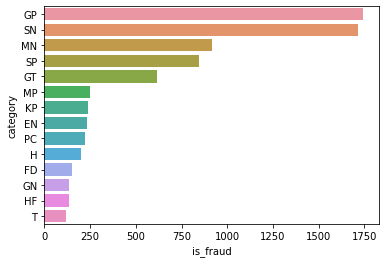

In [87]:
sns.barplot(data = cat, y='category', x='is_fraud', order=cat.sort_values(by='is_fraud', ascending=False).category);

In [211]:
train.shape

(1296675, 12)

Como não há na base de teste o estado 'DE', portanto este será retirado da base de treinamento.

In [212]:
train = train.drop(labels=train[train['state']=='DE'].index)

Dados desbalanceados 99.42% de não fraudulentos e somente 0.58% de fraudes.

In [213]:
train['is_fraud'].value_counts(normalize=True)

0    0.994218
1    0.005782
Name: is_fraud, dtype: float64

In [214]:
train.shape

(1296666, 12)

In [215]:
train_dum = pd.get_dummies(train, columns=['category','state'])


test_dum = pd.get_dummies(test, columns=['category','state'])
train_dum.shape, test_dum.shape



((1296666, 74), (555719, 74))

In [216]:
train_dum

,amt,gender,lat,long,city_pop,yb,merch_lat,merch_long,is_fraud,hour,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,4.97,0,36.0788,-81.1781,3495,1988,36.011293,-82.048315,0,0,...,0,0,0,0,0,0,0,0,0,0
1,107.23,0,48.8878,-118.2105,149,1978,49.159047,-118.186462,0,0,...,0,0,0,0,0,0,1,0,0,0
2,220.11,1,42.1808,-112.2620,4154,1962,43.150704,-112.154481,0,0,...,0,0,0,0,0,0,0,0,0,0
3,45.00,1,46.2306,-112.1138,1939,1967,47.034331,-112.561071,0,0,...,0,0,0,0,0,0,0,0,0,0
4,41.96,1,38.4207,-79.4629,99,1986,38.674999,-78.632459,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,1,37.7175,-112.4777,258,1961,36.841266,-111.690765,0,12,...,0,0,0,1,0,0,0,0,0,0
1296671,51.70,1,39.2667,-77.5101,100,1979,38.906881,-78.246528,0,12,...,0,0,0,0,0,0,0,0,0,0
1296672,105.93,1,32.9396,-105.8189,899,1967,33.619513,-105.130529,0,12,...,0,0,0,0,0,0,0,0,0,0
1296673,74.90,1,43.3526,-102.5411,1126,1980,42.788940,-103.241160,0,12,...,1,0,0,0,0,0,0,0,0,0


In [217]:
test_dum

,amt,gender,lat,long,city_pop,yb,merch_lat,merch_long,is_fraud,hour,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,2.86,1,33.9659,-80.9355,333497,1968,33.986391,-81.200714,0,12,...,0,0,0,0,0,0,0,0,0,0
1,29.84,0,40.3207,-110.4360,302,1990,39.450498,-109.960431,0,12,...,0,0,0,1,0,0,0,0,0,0
2,41.28,0,40.6729,-73.5365,34496,1970,40.495810,-74.196111,0,12,...,0,0,0,0,0,0,0,0,0,0
3,60.05,1,28.5697,-80.8191,54767,1987,28.812398,-80.883061,0,12,...,0,0,0,0,0,0,0,0,0,0
4,3.19,1,44.2529,-85.0170,1126,1955,44.959148,-85.884734,0,12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,1,40.4931,-91.8912,519,1966,39.946837,-91.333331,0,23,...,0,0,0,0,0,0,0,0,0,0
555715,111.84,1,29.0393,-95.4401,28739,1999,29.661049,-96.186633,0,23,...,0,0,1,0,0,0,0,0,0,0
555716,86.88,0,46.1966,-118.9017,3684,1981,46.658340,-119.715054,0,23,...,0,0,0,0,0,0,1,0,0,0
555717,7.99,1,44.6255,-116.4493,129,1965,44.470525,-117.080888,0,23,...,0,0,0,0,0,0,0,0,0,0


In [218]:
X_train = train_dum.drop(['is_fraud'], axis=1)
y_train = train_dum.loc[:,'is_fraud']
X_test = test_dum.drop(['is_fraud'], axis=1)
y_test = test_dum.loc[:,'is_fraud']


In [219]:
featuresToScale = X_train.columns
featuresToScale

Index(['amt', 'gender', 'lat', 'long', 'city_pop', 'yb', 'merch_lat',
       'merch_long', 'hour', 'category_EN', 'category_FD', 'category_GN',
       'category_GP', 'category_GT', 'category_H', 'category_HF',
       'category_KP', 'category_MN', 'category_MP', 'category_PC',
       'category_SN', 'category_SP', 'category_T', 'state_AK', 'state_AL',
       'state_AR', 'state_AZ', 'state_CA', 'state_CO', 'state_CT', 'state_DC',
       'state_FL', 'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA', 'state_MD',
       'state_ME', 'state_MI', 'state_MN', 'state_MO', 'state_MS', 'state_MT',
       'state_NC', 'state_ND', 'state_NE', 'state_NH', 'state_NJ', 'state_NM',
       'state_NV', 'state_NY', 'state_OH', 'state_OK', 'state_OR', 'state_PA',
       'state_RI', 'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY'],
      dtype='ob

In [220]:
X_test

,amt,gender,lat,long,city_pop,yb,merch_lat,merch_long,hour,category_EN,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,2.86,1,33.9659,-80.9355,333497,1968,33.986391,-81.200714,12,0,...,0,0,0,0,0,0,0,0,0,0
1,29.84,0,40.3207,-110.4360,302,1990,39.450498,-109.960431,12,0,...,0,0,0,1,0,0,0,0,0,0
2,41.28,0,40.6729,-73.5365,34496,1970,40.495810,-74.196111,12,0,...,0,0,0,0,0,0,0,0,0,0
3,60.05,1,28.5697,-80.8191,54767,1987,28.812398,-80.883061,12,0,...,0,0,0,0,0,0,0,0,0,0
4,3.19,1,44.2529,-85.0170,1126,1955,44.959148,-85.884734,12,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,43.77,1,40.4931,-91.8912,519,1966,39.946837,-91.333331,23,0,...,0,0,0,0,0,0,0,0,0,0
555715,111.84,1,29.0393,-95.4401,28739,1999,29.661049,-96.186633,23,0,...,0,0,1,0,0,0,0,0,0,0
555716,86.88,0,46.1966,-118.9017,3684,1981,46.658340,-119.715054,23,0,...,0,0,0,0,0,0,1,0,0,0
555717,7.99,1,44.6255,-116.4493,129,1965,44.470525,-117.080888,23,0,...,0,0,0,0,0,0,0,0,0,0


Diminuir a quantidade de dados com o RandomUnderSampler para equilibrar as variáveis 0 e 1 do "is_fraud".

0    7497
1    7497
Name: is_fraud, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


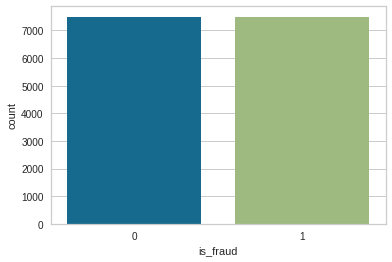

In [221]:
from imblearn.under_sampling import RandomUnderSampler
X_train, y_train = RandomUnderSampler().fit_resample(X_train, y_train)
print(pd.Series(y_train).value_counts())
sns.countplot(y_train)

In [222]:
X_train.shape, y_train.shape

((14994, 73), (14994,))

In [223]:
X_test.shape

(555719, 73)

Padronizar os dados para evitar que valores mais altos tenham pesos maiores durante a aprendizagem de máquina, distorcendo a resposta dada.

In [226]:
sX = pp.StandardScaler(copy=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

## 5.  Machine Learning - Treinamento supervisionado

In [ ]:

rf_cls = RandomForestClassifier(random_state=0)#  class_weight='balanced')

param_dist = {"n_estimators": [20,30,50,100,300,500],
              'max_depth': [None,2,4,6],
              "min_samples_leaf": [1,3,5],
              "min_samples_split": [2,4,6],
              "criterion": ["gini"]
              }

#rf_rs = RandomizedSearchCV(rf_cls, param_distributions=param_dist, cv=5, n_iter =25,verbose=True,random_state=0,scoring='recall', n_jobs=-1).fit(X_train,y_train)
rf_rs = GridSearchCV(estimator=rf_cls,param_grid=param_dist,scoring='roc_auc', verbose=True, n_jobs=-1).fit(X_train,y_train)



print('Best params achieve a train score of', abs(rf_rs.best_score_),'with the params:')
rf_rs.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best params achieve a train score of 0.9950619889948129 with the params:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 300}

Precision de 15% porque há bem mais dados 0 do que 1, então a equação com TP/(TP+TN) o TN = 11144 é muito alto em comparação a quantidade de TP, então dará um valor baixo.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


AUC: 0.9679560999431512
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.16      0.96      0.28      2145

    accuracy                           0.98    555719
   macro avg       0.58      0.97      0.63    555719
weighted avg       1.00      0.98      0.99    555719

Cross validation Scores:
 [0.99360307 0.99349033 0.99445497 0.99469046 0.99502871]
Cross validation Scores Mean:
 0.9942535066072512


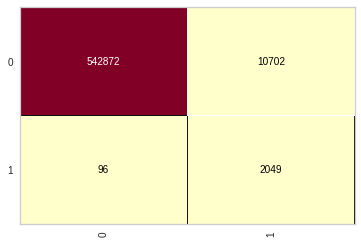

In [228]:
rf_cls = RandomForestClassifier(random_state=0,
                                min_samples_leaf=1,
                                min_samples_split=4,
                                n_estimators=300).fit(X_train,y_train)#,class_weight="balanced",

rf_cross = cross_val_score(rf_cls, X_train,y_train, cv=5 ,scoring='roc_auc')


y_pred_rf = rf_cls.predict(X_test)



from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(rf_cls)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)


print("AUC: {}".format(roc_auc_score(y_test, y_pred_rf)))
print(classification_report(y_test, y_pred_rf))  
print('Cross validation Scores:\n', (rf_cross))
print('Cross validation Scores Mean:\n', (rf_cross.mean()))

Retirada de valores menos importantes considerados durante o RandomForestClassifier. No caso, os valores menores que 0.0005 serão retirados.De 76 atributos foi para 56.

In [229]:
features_importances = pd.DataFrame({'features': featuresToScale,'importances':rf_cls.feature_importances_}).sort_values(by='importances',ascending = False)
print(display(features_importances[:55]))


features = list(features_importances[features_importances['importances']>0.0005].features)
len(features)

,features,importances
0,amt,0.508997
8,hour,0.182592
5,yb,0.027343
13,category_GT,0.023598
6,merch_lat,0.020512
12,category_GP,0.020430
4,city_pop,0.020245
7,merch_long,0.019750
20,category_SN,0.019579
2,lat,0.017593


None


56

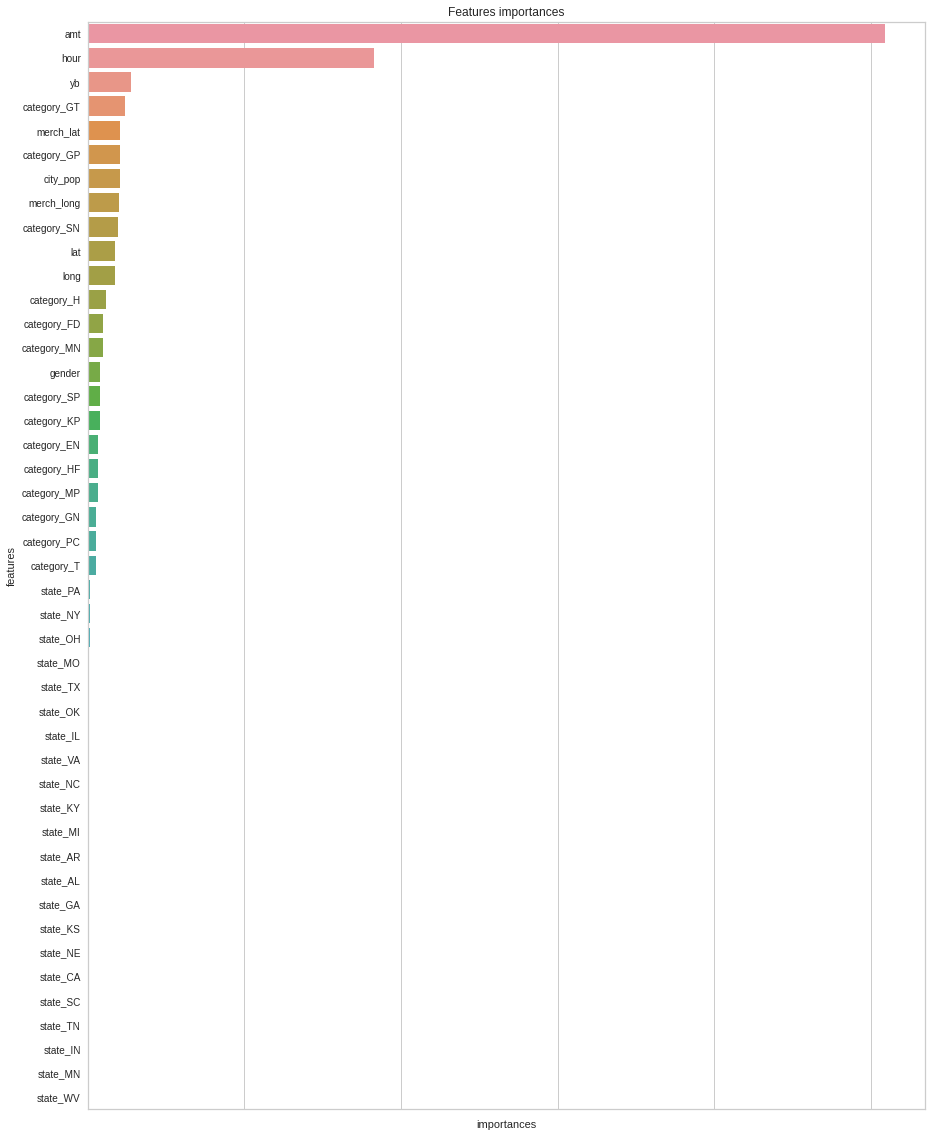

In [230]:
plt.figure(figsize = (15,20))
plt.title('Features importances')
s = sns.barplot(y='features',x='importances',data=features_importances[:45],orient='h')
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [231]:
X_train = X_train[features]
X_test = X_test[features]
X_train.shape, X_test.shape

((14994, 56), (555719, 56))

In [232]:
rf_cls = RandomForestClassifier(random_state=0)#  class_weight='balanced')

param_dist = {"n_estimators": [500,600,700],
              'max_depth': [None,1],
              "min_samples_leaf": [1,2],
              "min_samples_split": [4,5,6],
              "criterion": ["gini"]
              }

#rf_rs = RandomizedSearchCV(rf_cls, param_distributions=param_dist, cv=5, n_iter =25,verbose=True,random_state=0,scoring='recall', n_jobs=-1).fit(X_train,y_train)
rf_rs = GridSearchCV(estimator=rf_cls,param_grid=param_dist,scoring='roc_auc', verbose=True, n_jobs=-1).fit(X_train,y_train)



print('Best params achieve a train score of', abs(rf_rs.best_score_),'with the params:')
rf_rs.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params achieve a train score of 0.9948596562855705 with the params:


{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 600}

In [114]:
rf_cls = RandomForestClassifier(random_state=0,
                                min_samples_leaf=1,
                                min_samples_split=5,
                                n_estimators=600).fit(X_train,y_train)

rf_cross = cross_val_score(rf_cls, X_train,y_train, cv=5 ,scoring='roc_auc')


y_pred_rf = rf_cls.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


AUC: 0.9650316810138261
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.15      0.95      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.58      0.97      0.63    555719
weighted avg       1.00      0.98      0.99    555719

Cross validation Scores:
 [0.99526395 0.99510563 0.99420947 0.99556549 0.99606987]
Cross validation Scores Mean:
 0.9952428826986133


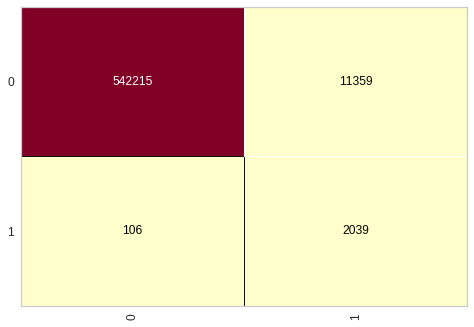

In [116]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(rf_cls)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)


print("AUC: {}".format(roc_auc_score(y_test, y_pred_rf)))
print(classification_report(y_test, y_pred_rf))  
print('Cross validation Scores:\n', (rf_cross))
print('Cross validation Scores Mean:\n', (rf_cross.mean()))

In [108]:
xgb_cls = XGBClassifier(random_state=0, n_jobs=-1, objective='binary:logistic')

space = {'max_depth': (5,12,'uniform'),
         'n_estimators':(50,100,'uniform'),
         'eta':(0.01,0.07,'uniform'),
         'colsample_bytree':(0.7,1.0,'uniform'),
         'subsample':(0.7,1.0,'uniform'),
         'min_child_weight':(0,2,'uniform')}


opt = BayesSearchCV(xgb_cls,search_spaces=space,random_state=0,n_iter=100,scoring='roc_auc',n_jobs=-1).fit(X_train,y_train)

In [109]:
print('Best params achieve a test score of', abs(opt.score(X_test, y_test)), ':')
print('Best params achieve a train score of', abs(opt.best_score_),':')
opt.best_params_

Best params achieve a test score of 0.9974640851085554 :
Best params achieve a train score of 0.9975054970306347 :


OrderedDict([('colsample_bytree', 0.9044445770317002),
             ('eta', 0.049458317338310166),
             ('max_depth', 10),
             ('min_child_weight', 2),
             ('n_estimators', 76),
             ('subsample', 1.0)])

In [110]:
xgb_cls = XGBClassifier(max_depth=10,
                        eta=0.05,
                        colsample_bytree=0.9,
                        subsample= 1, 
                        n_estimators=76,
                        min_child_weight=2,
                        random_state=0,
                        n_jobs=-1,
                        objective='binary:logistic').fit(X_train,y_train)

AUC: 0.9756361078204228
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.15      0.97      0.26      2145

    accuracy                           0.98    555719
   macro avg       0.57      0.98      0.62    555719
weighted avg       1.00      0.98      0.99    555719

Cross validation Scores:
 [0.9970358  0.99782611 0.99624149 0.99805826 0.99836582]
Cross validation Scores Mean:
 0.9975054970306347


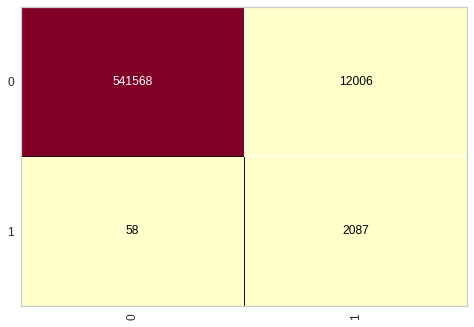

In [112]:
xgb_cross = cross_val_score(xgb_cls, X_train,y_train, cv=5, scoring='roc_auc')


y_pred_xgb = xgb_cls.predict(X_test)

from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(xgb_cls)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)


print("AUC: {}".format(roc_auc_score(y_test, y_pred_xgb)))
print(classification_report(y_test, y_pred_xgb))  
print('Cross validation Scores:\n', (xgb_cross))
print('Cross validation Scores Mean:\n', (xgb_cross.mean()))

#6. Conclusão

O RandomForestClassifier tem um AUC de 0.97 e um número de Recall de 0.95, um pouco menor que o Xgbclassifier que obteve um AUC de 0.98 e um Recall de 0.97. É importante perceber que o número de Falso Positivos do Random Forest foi menor (com 11359) que o Xgbclassifier (com 12006), contudo, no caso de análise de fraudes, os valores do Falso Negativos são mais importantes. Isto é devido a maior importância em detectar o maior número possível de fraudes, ou seja, não detectar uma fraude pode trazer muitos prejuízos para a empresa, contudo, considerar uma transação fraudulenta sem o ser, somente trará algum desconforto para o usuário que terá sua conta bloqueada. Conclui-se, então, que o modelo Xgbclassifier teve uma performance melhor e será o utilizado para este conjunto de dados.